# IOB compression of MS-COCO CLIP latents

This notebook demonstrates autoencoding compression of latent CLIP embeddings of real images in the MS-COCO dataset with IOB layers. Each image is first embedded into the CLIP latent space using a pre-trained semantic embedding and then compressed and reconstructed with an IOB autoencoder. The reconstructed embeddings are then used to condition a pre-trained diffusion model to generate images. We use IOBs here to study this embedding compression as a function of bottleneck width and estimate the minimal global intrinsic dimensionality.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from scipy.stats import chi2
from sklearn.datasets import make_s_curve
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from iobs.layers import IOBLayer
from iobs.models import BaseAE

/data80/mattho/anaconda3/envs/aeDROP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The huggingface pretrained Unclip model will only run on GPU systems of sufficient memory
device = 'cuda'
print('Device:', device)

Device: cuda


## Load pretrained UnCLIP model

In [3]:
from diffusers import StableUnCLIPImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip-small", torch_dtype=torch.float16, variation="fp16"
)
pipe = pipe.to(device)
pipe.enable_model_cpu_offload()
pipe.disable_vae_slicing()

dtype = next(pipe.image_encoder.parameters()).dtype
height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = height
def embed_image(images):
    x = pipe.feature_extractor(images=images, return_tensors="pt").pixel_values
    x = x.to(device=device, dtype=dtype)
    return pipe.image_encoder(x).image_embeds

def gen_latents():
    batch_size = 1
    num_channels_latents = pipe.unet.config.in_channels
    device = pipe._execution_device
    return pipe.prepare_latents(batch_size, num_channels_latents, height, width, dtype, device, generator=None)

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


## Generate dataset

In [4]:
import torchvision.datasets as dset

path2data="/home/mattho/data/MS-COCO/train2017"
path2json="/home/mattho/data/MS-COCO/annotations/captions_train2017.json"

coco_train = dset.CocoCaptions(root = path2data,
                               annFile = path2json)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


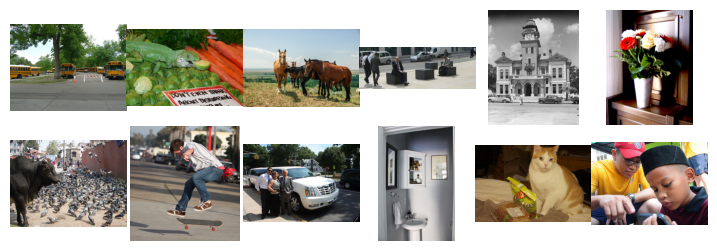

In [5]:
# plot some example images
N, M = 2,6
f, axs = plt.subplots(N,M,figsize=(M*1.5,N*1.5), gridspec_kw={'hspace':0, 'wspace':0})
for i in range(N):
    for j in range(M):
        ind = np.random.randint(len(coco_train))
        axs[i,j].imshow(coco_train[ind][0])
        axs[i,j].axis('off')

In [ ]:
# embed all MS-COCO images into the CLIP latent space (takes ~40 mins)
def collate_fn(data):
    images, labels = zip(*data)
    return images

bs = 32
dim = 768
loader = DataLoader(coco_train, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=1)

data = np.zeros((len(coco_train),dim))
for i, batch in enumerate(tqdm.tqdm(loader)):
    data[i*bs:(i+1)*bs] = embed_image(batch).cpu().detach().numpy()

In [6]:
# save yourself the time later
# np.save('data/COCO768/clip_embeds.npy', embeds)
data = np.load('/home/mattho/data/aeDROP/data/COCO768/clip_embeds.npy')

In [7]:
# split into training, validation, and testing folds via 80-10-10
nfolds = 10
np.random.seed(12345)
folds = np.random.choice(nfolds, size=len(data))

in_train = folds < nfolds-2
in_val = folds == nfolds-2
in_test = folds == nfolds-1

In [8]:
# create dataset and dataloaders
class SimulatedDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx])
        return self.data[idx], self.labels[idx]

train_dataset = SimulatedDataset(data[in_train], np.argwhere(in_train).flatten())
val_dataset = SimulatedDataset(data[in_val], np.argwhere(in_val).flatten())
test_dataset = SimulatedDataset(data[in_test], np.argwhere(in_test).flatten())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Define encoder-decoder architecture

In [9]:
def build_dense_sequence(shape_list):
    """Convenience function for building a sequence of dense (Linear) layers"""
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

# define a fully-connected encoder
encoder = nn.Sequential(
    *(build_dense_sequence([768, 384, 384, 384])),
).to(device)

# define a fully-connected decoder
decoder = nn.Sequential(
    *(build_dense_sequence([384, 384, 384, 768])),
).to(device)

# define a IOB with a max width of 4 features
bottleneck = IOBLayer(384, device=device)

In [10]:
# build a simple autoencoder model
model = BaseAE(
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
)

In [11]:
# define a criterion for log-likelihood maximization
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs = model.forward_all(batch_features)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    return loss

## Train

In [12]:
# Set hyperparameters

# training
max_epochs = 3000
lr = 5e-5
print_every = 10

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

In [ ]:
# this takes several hours

trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()*len(batch_features)
    trloss = trloss / len(train_dataset)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features, _ in val_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()*len(batch_features)
        valoss = valoss / len(val_dataset)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    if epoch % print_every == 0:
        print(f"epoch : {epoch + 1}/{max_epochs}, "
              f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

In [13]:
# save yourself the time later
# torch.save(model.state_dict(), '/home/mattho/data/aeDROP/saved_models/tutorial/coco-model.dat')
# np.save('/home/mattho/data/aeDROP/saved_models/tutorial/coco-loss.npy',
#         {'trloss_rec':trloss_rec, 'valoss_rec':valoss_rec}
# )

model.load_state_dict(
    torch.load('/home/mattho/data/aeDROP/saved_models/tutorial/coco-model.dat', map_location=torch.device('cpu'))
)
model = model.to(device)
losses = np.load('/home/mattho/data/aeDROP/saved_models/tutorial/coco-loss.npy', allow_pickle=True).item()
trloss_rec = losses['trloss_rec']
valoss_rec = losses['valoss_rec']

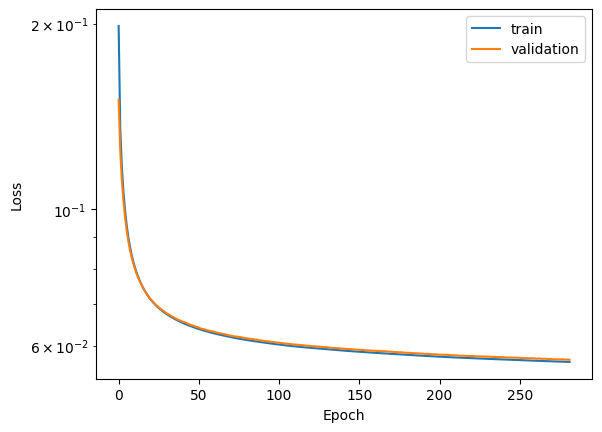

In [14]:
# plot loss vs. time
lenrec = len(trloss_rec)

f, ax = plt.subplots()
ax.semilogy()
ax.plot(range(lenrec), trloss_rec, label='train')
ax.plot(range(lenrec), valoss_rec, label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend()

## Test

In [15]:
# generate several reconstruction examples with unCLIP diffusion
Nsamp = 4 # number of images to sample
n_opens = (3*2**(np.arange(8))).astype(int) # bottleneck widths

batch_features, idxs = next(iter(test_loader))
batch_features = batch_features.float().to(device)
inds = np.random.choice(len(batch_features), Nsamp, replace=False)

samp_ims = np.zeros((Nsamp, len(n_opens), height, width, 3), dtype=int)
full_ims = np.zeros((Nsamp, height, width, 3), dtype=int)
true_ims = []
for i, ind in enumerate(inds):
    print(ind)
    latents = gen_latents()
    inputs = batch_features[ind:ind+1]
    
    true_ims.append(coco_train[idxs[ind]][0])
    with torch.no_grad():
        full_ims[i] = pipe(
            image_embeds=inputs.to(dtype=dtype),
            latents=latents,
            num_inference_steps=20
        )[0][0]
        for j, n_open in enumerate(n_opens):
            embed = model.forward_neck(inputs, n_open).to(dtype=dtype)
            samp_ims[i,j] = pipe(
                image_embeds=embed,
                latents=latents,
                num_inference_steps=20
            )[0][0]

86


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


17


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


0


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


115


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


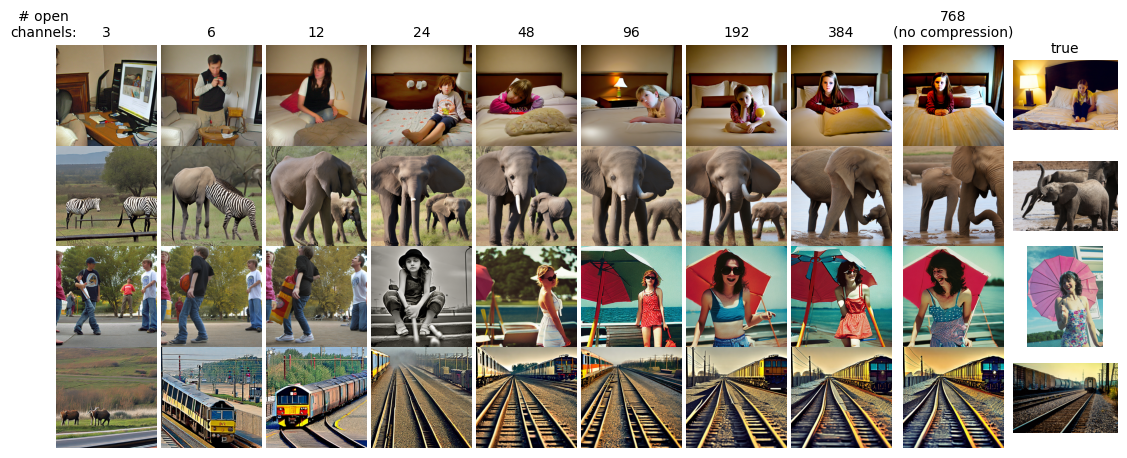

In [16]:
f = plt.figure(figsize=(1.4*(len(n_opens)+2), 3.6*(len(inds)))) #(2*(len(n_opens)+2), len(inds)*2))) # 
gs = mpl.gridspec.GridSpec(
    len(inds)*3-1, 
    len(n_opens)+5, 
    hspace=0, 
    wspace=0,
    width_ratios=[3]+[15]*len(n_opens)+[1,15,1,15]
)
ax = f.add_subplot(gs[0,0])
ax.axis('off')
ax.set_title('# open\nchannels:', fontsize=10)
for i, ind in enumerate(inds):
    for j, n_open in enumerate(n_opens):
        ax = f.add_subplot(gs[i,j+1])
        ax.imshow(samp_ims[i,j])
        ax.axis('off')
        if i==0: ax.set_title(n_open, fontsize=10)
    ax = f.add_subplot(gs[i,-3])
    ax.imshow(full_ims[i])
    ax.axis('off')
    if i==0: ax.set_title('768\n(no compression)', fontsize=10)
    
    ax = f.add_subplot(gs[i,-1])
    ax.imshow(true_ims[i])
    ax.axis('off')
    if i==0: ax.set_title('true', fontsize=10)

In [17]:
# embed and reconstruct all test images, for all possible bottleneck widths
# save only the loss to minimize memory usage

n_opens = range(model.latent_dim+1)

teloss_rec = []
with torch.no_grad():
    for i, n_open in enumerate(tqdm.tqdm(n_opens)):
        teloss = 0
        for j, (batch_features, _) in enumerate(test_loader):
            batch_features = batch_features.float().to(device)
            outputs = model.forward_neck(batch_features, n_open)
            batch_loss = (outputs-batch_features)**2
            teloss += batch_loss.sum().item()
        teloss_rec.append(teloss)
testvar = np.sum(np.var(test_dataset.data, axis=0))
test_percerr = np.array(teloss_rec)/testvar/len(test_dataset)

100%|██████████| 385/385 [00:59<00:00,  6.49it/s]


Text(0, 0.5, '$\\mathrm{MSE}/\\sigma^2_\\mathrm{pop}$')

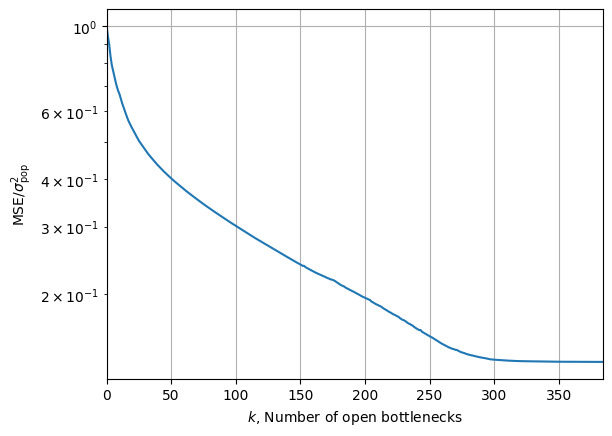

In [18]:
# plot the % variance explained, as a function of bottlneeck width
f,ax = plt.subplots()
ax.semilogy()
ax.plot(test_percerr)
ax.grid()
ax.set_xlim(0, model.latent_dim)
ax.set_xlabel('$k$, Number of open bottlenecks')
ax.set_ylabel('$\mathrm{MSE}/\sigma^2_\mathrm{pop}$')

## Calculate intrinsic dimensionality

In [19]:
# calculate intrinisic dimensionality

p = 0.05  # p-value at which to reject the null hypothesis
diff_loglik = -np.diff(test_percerr/2)*len(test_dataset)
intdim = np.argwhere(diff_loglik<chi2.isf(p,1))[0,0]
print(f'Intrinsic Dimensionality: {intdim}')

Intrinsic Dimensionality: 152
